# Pipeline de transformación y exploración gráfica de los datos.

El propósito de este notebook es crear un conjunto de funciones que nos ayuden a preparar y transformar los datos para el resto de las operaciones. También se muestran aquí las gráficas del slide deck del EDA. 

In [1]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.ticker import FuncFormatter

In [2]:
#define categorical, numerical and date columns
CAT_COLS = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

DATE_COLS = ["fecha_creacion", "fecha_cierre"]

NUM_COLS = ["latitud", "longitud"]

In [9]:
#esto irá en el script ingestion .py
def ingest_file(file_name):
    """
    Function to retrieve and return the accidents dataset.
    Parameters:
    -----------
    file_name: str
               Path to the file.
    Returns:
    --------
    df: pandas dataframe
    """
    df = pd.read_csv(file_name)
    return df


def drop_cols(df):
    """
    Function to drop unnnecesary columns in the dataset.
    """
    df.drop(columns = ['folio', 'geopoint'], inplace = True)
    return df



def fill_na(df):
    """
    Function to fill null values in a dataframe.
    """
    #aquí podemos ir agregando más cosas cuando descubramos 
    #cómo imputar valores faltantes para latitud y longitud
    df.fillna({
        'delegacion_inicio': 'No Disponible',
        'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df


def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

def create_categorical(cols, df):
    """
    Function to transform and prepare the categorical features in the dataset.
    """
    #transform to appropriate data type
    for col in cols: 
        df = categoric_transformation(col, df)
     
    return df


def date_transformation(col,df):
    """
    Function to prepare and transform date-type columns. 
    """
    df[col] = pd.to_datetime(df[col])
    return df

def create_date_cols(cols, df):
    for col in cols:
        df = date_transformation(col, df)
    return df 



def generate_label(df):
    """
    Function to create a new column indicating whether there was
    a false alarm or not. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    --------
    df: pandas dataframe
    """
    #transformamos la columna para solo quedarnos con la letra del código
    df["codigo_cierre"] = df["codigo_cierre"].apply(lambda x: x[1])
    df['label'] = np.where(
        (df.codigo_cierre == 'F') | (df.codigo_cierre == 'N'), 1, 0)
    return df 

def create_simple_hour(df):
    """
    Function to extract the hour from the column "hora_creacion"
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the hour. 
    """
    #la función se podria adaptar para devolver minuto o segundo pero no lo considero necesario
    pattern = '\d+' #encuentra uno o más dígitos
    horas_raw = df.hora_creacion.values #son así: '22:35:04', '22:50:49', '09:40:11'
    n = len(horas_raw)
    horas_clean = [0]*n #es más rápido reasignar valores que hacer .append()
    for i in range(n):
        hora_raw = horas_raw[i]
        hora_clean = re.match(pattern, hora_raw)[0] #solo queremos la hora, esto devuelve un objeto
        horas_clean[i] = hora_clean
    
    df["hora_simple"] = horas_clean
    return df 

def create_time_blocks(df):
    """
    Function to group the hour of the day into 3-hour blocks.
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the time-block.
    """
    horas_int = set(df.hora_simple.astype(int).values) #estaba como categórico
    f = lambda x: 12 if x == 0 else x
    mapping_hours = {}
    for hora in horas_int:
        grupo = (hora // 3) * 3
        if grupo < 12: 
            nombre_grupo = str(f(grupo)) + "-" + str(grupo + 2) + " a.m."
        else:
            hora_tarde = grupo % 12
            nombre_grupo = str(f(hora_tarde)) + "-" + str(hora_tarde + 2) + " p.m."
        mapping_hours[hora] = nombre_grupo
    
    df["espacio_del_dia"] = df["hora_simple"].astype(int).map(mapping_hours)
    return df
    
    
def basic_preprocessing(path):
    """
    Function to summarize all the preprocessing done to the data.
    Parameters:
    -----------
    path: str
          Path to your file
    
    Returns:
    ---------
    df: pandas dataframe
    """
    df = ingest_file(path) 
    df = drop_cols(df) 
    df = generate_label(df) 
    df = fill_na(df) 
    df = create_categorical(CAT_COLS, df) #transform to appropriate data types
    df = create_date_cols(DATE_COLS, df)
    df = create_simple_hour(df)
    df = create_time_blocks(df)
    
    return df


In [10]:
data = basic_preprocessing('incidentes-viales-c5.csv')
data.head()

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,label,hora_simple,espacio_del_dia
0,2016-01-23,22:35:04,Sábado,A,2016-01-24,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,1,0,22,9-11 p.m.
1,2016-01-23,22:50:49,Sábado,A,2016-01-24,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,1,0,22,9-11 p.m.
2,2016-01-24,09:40:11,Domingo,N,2016-01-24,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,1,1,09,9-11 a.m.
3,2016-01-24,22:40:57,Domingo,N,2016-01-24,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,1,1,22,9-11 p.m.
4,2016-01-24,04:25:15,Domingo,A,2016-01-24,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,1,0,04,3-5 a.m.


## Proporción de llamadas falsas por delegación de 2014-2020.

Es natural preguntarse cuál es la proporción de llamadas falsas o negativas (las que tienen label == 1) para cada delegación en cada año.

In [11]:
#el promedio de una columna de 0's y 1's es la proporción de 1's en esa columna. 
prop = data.groupby(["delegacion_inicio", "año_cierre"], as_index = False).agg({"label": "mean"})
prop = prop[prop.delegacion_inicio != "No Disponible"]
prop.head()

,delegacion_inicio,año_cierre,label
0,ALVARO OBREGON,2014,0.191353
1,ALVARO OBREGON,2015,0.212616
2,ALVARO OBREGON,2016,0.250545
3,ALVARO OBREGON,2017,0.230592
4,ALVARO OBREGON,2018,0.217359


In [12]:
#solo son 7 años y tengo 8 campos
#tengo que agregar un campo adicional para llenar el facet grid; agreguemos el promedio
promedio = prop.groupby(['delegacion_inicio'], as_index=False).agg({'label': 'mean'})
promedio = promedio[promedio.delegacion_inicio != "No Disponible"].sort_values(by=["label"], ascending=False)
promedio["delegacion_inicio"] = [e.lower().title() for e in promedio.delegacion_inicio.values]

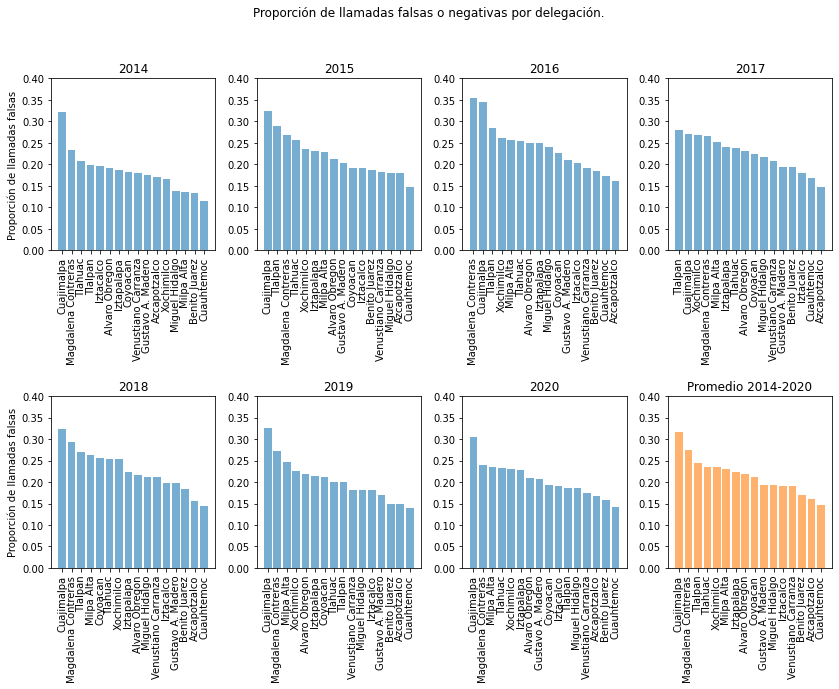

In [16]:
#paso 1: inicializar el agrupamiento
#el promedio de una columna de 0's y 1's es la proporción de 1's en esa columna. 
#encontramos la proporción de label por delegación
prop = data.groupby(["delegacion_inicio", "año_cierre"], as_index = False).agg({"label": "mean"})
prop = prop[prop.delegacion_inicio != "No Disponible"] #recordemos que así llenamos los Nans por colonia

#paso 2: inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .85, bottom = .20)
fig.suptitle('Proporción de llamadas falsas o negativas por delegación.')

#paso 3: llenar el facet grid 
for i in range(8):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = prop[prop["año_cierre"] == año].sort_values(by = "label", ascending = False)
    delegaciones = [e.lower().title() for e in grouping.delegacion_inicio.values]
    axs[row,col].bar(grouping.delegacion_inicio, grouping.label, align='center', alpha=0.6)
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([0,.40])
    axs[row,col].set_xticks(range(16))
    axs[row,col].set_xticklabels(delegaciones, rotation = 90)
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "Proporción de llamadas falsas")
    #campo del promedio se llena de formam distinta
    if row == 1 and col == 3: 
        axs[row,col].bar(promedio.delegacion_inicio, promedio.label, align = "center", alpha=0.6)
        delegaciones = [e for e in promedio.delegacion_inicio.values]
        axs[row,col].set_title("Promedio 2014-2020")
        axs[row,col].set_ylim([0,.40])
        axs[row,col].set_xticks(range(16))
        axs[row,col].set_xticklabels(delegaciones, rotation = 90)
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.show();
#TO DO: poner solo las top 5 delegaciones no? 

## Llamadas falsas o negativas por día de la semana.

También es natural preguntarse qué días de la semana tuvieron más llamadas falsas. También podemos dividir por año el facetgrid. 

In [17]:
dia_semana = data.groupby(["dia_semana", "año_cierre"], as_index = False).agg({"label": "mean"})
dia_semana.head()

,dia_semana,año_cierre,label
0,Domingo,2014,0.172587
1,Domingo,2015,0.196048
2,Domingo,2016,0.208634
3,Domingo,2017,0.197158
4,Domingo,2018,0.190001


In [18]:
prom_dia = dia_semana.groupby(["dia_semana"], as_index = False).agg({'label': 'mean'})
prom_dia = prom_dia.sort_values(by=["label"],ascending = False)
prom_dia

,dia_semana,label
6,Viernes,0.217258
4,Miércoles,0.206853
1,Jueves,0.206537
3,Martes,0.204935
2,Lunes,0.200205
5,Sábado,0.193255
0,Domingo,0.188855


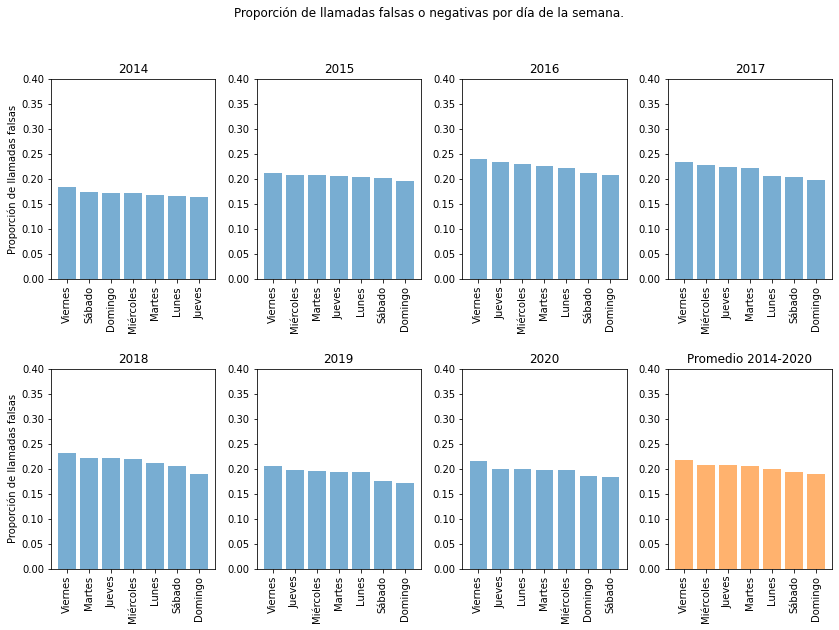

In [19]:
#paso 1: inicializar el agrupamiento y crear los promedios 
dia_semana = data.groupby(["dia_semana", "año_cierre"], as_index = False).agg({"label": "mean"})
#promedio
prom_dia = dia_semana.groupby(["dia_semana"], as_index = False).agg({'label': 'mean'})
prom_dia = prom_dia.sort_values(by=["label"],ascending = False)
#paso 2: inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
fig.suptitle('Proporción de llamadas falsas o negativas por día de la semana.')

#paso 3: llenar el facet grid 
for i in range(8):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = dia_semana[dia_semana["año_cierre"] == año].sort_values(by = "label", ascending = False)
    dias = [e.lower().title() for e in grouping.dia_semana.values]
    axs[row,col].bar(grouping.dia_semana, grouping.label, align='center', alpha=0.6)
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([0,.40])
    axs[row,col].set_xticks(range(7))
    axs[row,col].set_xticklabels(dias, rotation = 90)
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "Proporción de llamadas falsas")
    #campo del promedio se llena de forma distinta
    if row == 1 and col == 3: 
        axs[row,col].bar(prom_dia.dia_semana, prom_dia.label, align = "center", alpha=0.6)
        dias = [e for e in prom_dia.dia_semana.values]
        axs[row,col].set_title("Promedio 2014-2020")
        axs[row,col].set_ylim([0,.40])
        axs[row,col].set_xticks(range(7))
        axs[row,col].set_xticklabels(dias, rotation = 90)
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.show();

Podemos ver que indudablemente el viernes es el día en donde más llamadas falsas hay. Una pregunta que surge naturalmente al entender el día donde hay más llamadas falsas es, ¿en qué horario ocurren estas llamadas? Para esto podemos crear una variable adicional que indique el bloque de tiempo (en grupos de 3 horas) donde ocurren estas llamadas. 

In [22]:
#la variable se llama espacio_del_dia, y se ve así:
data.iloc[:5,12:]

,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,label,hora_simple,espacio_del_dia
0,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,1,0,22,9-11 p.m.
1,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,1,0,22,9-11 p.m.
2,EMERGENCIA,LLAMADA DEL 066,TLALPAN,1,1,09,9-11 a.m.
3,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,1,1,22,9-11 p.m.
4,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,1,0,04,3-5 a.m.


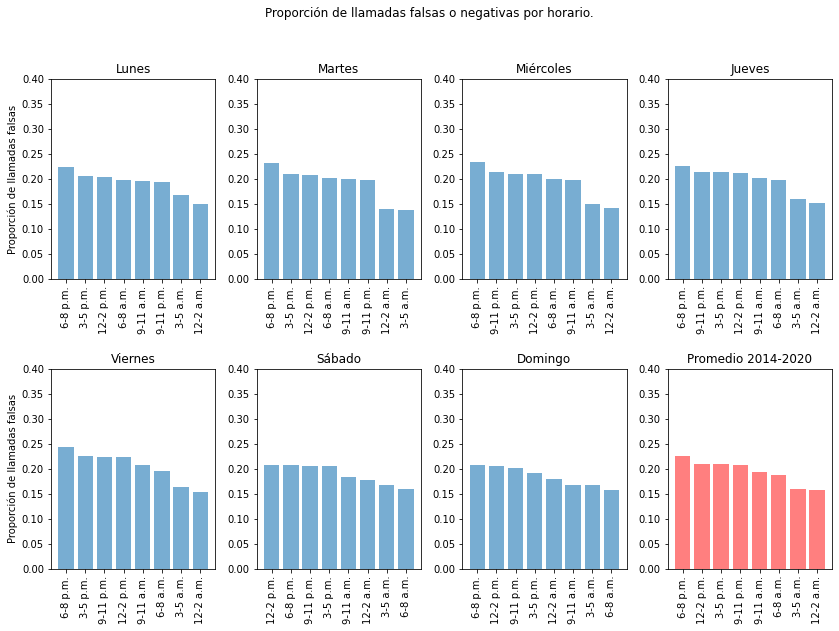

In [23]:
#paso 1: inicializar el agrupamiento y crear los promedios 
horario_frecuente = data.groupby(["espacio_del_dia", "dia_semana"], as_index = False).agg({"label": "mean"})
#promedio de todos los días 
prom_dia = horario_frecuente.groupby(["espacio_del_dia"], as_index = False).agg({'label': 'mean'})
prom_dia = prom_dia.sort_values(by=["label"],ascending = False)

#paso 2: inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
fig.suptitle('Proporción de llamadas falsas o negativas por horario.')

#paso 3: llenar el facet grid 
dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
for i in range(7):
    dia = dias[i] 
    row = i // 4  
    col = i % 4
    #filtramos solo por dia de la semana  
    grouping = horario_frecuente[horario_frecuente["dia_semana"] == dia].sort_values(by = "label", ascending = False)
    bloques_horarios = grouping["espacio_del_dia"].values.tolist()
    axs[row,col].bar(grouping.espacio_del_dia, grouping.label, align='center', alpha=0.6)
    axs[row,col].set_title(dia)
    axs[row,col].set_ylim([0,.40])
    axs[row,col].set_xticks(range(8))
    axs[row,col].set_xticklabels(bloques_horarios, rotation = 90)
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "Proporción de llamadas falsas")

#campo del promedio se llena de forma distinta
axs[1,3].bar(prom_dia.espacio_del_dia, prom_dia.label, align = "center", alpha=0.5, color="red")
bloques_horarios = prom_dia.espacio_del_dia.values.tolist()
axs[1,3].set_title("Promedio 2014-2020")
axs[1,3].set_ylim([0,.40])
axs[1,3].set_xticks(range(8))
axs[1,3].set_xticklabels(bloques_horarios, rotation = 90)
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.show();

# To do: 

* Arreglar el face grid de las mil delegaciones para poner el top 5
* Ver cómo aumentar el tamaño de letra del título de las gráficas
* Ir guardando algunas y ponerlas en el slide deck
* Hacer más gráficas 
* Poner las primeras tres barras de un color y luego de otro? 
* Ver en qué color pongo las de los promedios 
* Hacer un facet grid que sea, por año, cómo han evolucionado los horarios de tiempo más comunes
* Ver mis otras notas. 